# Single Point Energies and Geometry Optimizations

In this exercise we will perform constrained optimizations of ethenol, water, and cyclohexane. This exercise is based on Lab 4 of [Computational Chemistry for Chemistry Educators](http://www.computationalscience.org/ccce/about/labs/labs.php).

# Part 0 - Setting up the appropriate software

In [ ]:
#@title Install packages with pip
#@markdown pyscf (Python-based Simulations of Chemistry Framework), for QM electronic structure calculation \\
#@markdown jsme_notebook, to sketch structures \\
#@markdown pyberny, for optimization \\
#@markdown geometric, for optimization \\
#@markdown condacolab, to install other packages \\
#@markdown
#@markdown Installing condacolab will restart the kernel and you can continue with the next cell.

!pip install pyscf
!pip install git+https://github.com/pyscf/semiempirical
!pip install -U pyberny
!pip install geometric
!pip install jsme_notebook

try:
    import google.colab
    !pip install condacolab
    import condacolab
    condacolab.install_mambaforge()
except ModuleNotFoundError:
    pass

In [ ]:
#@title Install packages with conda
#@markdown rdkit, to generate initial structures from SMILES strings \\
#@markdown py3Dmol, for visualization of structures \\

try:
    import condacolab
    condacolab.check()
    !mamba install --yes -c conda-forge rdkit py3Dmol
except ModuleNotFoundError:
    on_colab = False
else:
    #check if installation was succesful
    try:
        import rdkit
        on_colab = True
        from IPython.display import clear_output
        clear_output()  # clear the excessive installation outputs
        print("Dependencies successfully installed!")
    except ModuleNotFoundError:
        print("Error while installing dependencies!")

# Part 1 - Determining the optimum structure for ethenol (vinyl alcohol)

We will perform an optimization of ethenol with a constraint on the C=C-O-H dihedral. This is pretty similar to Part 3 of Exercise 3, so I'll take off the training wheels just a little bit.

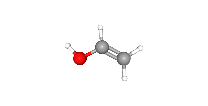

## Obtaining a SMILES string

In [ ]:
#@title You may use this widget to draw a molecule to get the SMILES string
from jsme_notebook import JSMENotebook
smiles = 'CCO'
jsme = JSMENotebook(smiles)

In [ ]:
#@title Run cell to generate SMILES code from cell above
jsme.smiles

Besides this widget there are several web servers that allow you to sketch a molecule to obtain a SMILES code, including at [the RCSB](https://www.rcsb.org/chemical-sketch) and [molview](https://molview.org/).

## Building an initial model

--> Enter the SMILES string of ethenol and run the cell below.

In [ ]:
#@title Structure generation and visualization
#@markdown rdkit is used to generate the structure and add hydrogen atoms \\
#@markdown py3dmol is used to visualize the structure
smiles = 'CCO' #@param

from rdkit import Chem
from rdkit.Chem import AllChem

rdkit_mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
AllChem.EmbedMolecule(rdkit_mol)

import py3Dmol
view = py3Dmol.view()
view.addModel(Chem.MolToMolBlock(rdkit_mol),'mol')
view.setStyle({'model':0}, {'stick': {}})
view.zoomTo()
view.show()

print(Chem.MolToXYZBlock(rdkit_mol))

In [ ]:
# Show a 2D representation of the molecule with indices labeled (starting 0)
dopts = Chem.Draw.rdMolDraw2D.MolDrawOptions()
dopts.addAtomIndices = True
display(Chem.Draw.MolsToGridImage([rdkit_mol], subImgSize=(600,600), drawOptions=dopts))

## Dihedral angle scan

Now we will compute the potential energy as a function of the dihedral angle. This is performed with a constrained minimization; the dihedral is set at a specific value at the rest of the system is allowed to relax to minimize the energy.

--> Enter in the correct indices for the dihedral angle and perform a dihedral scan at 15 degree intervals. Remember that rdkit (used to draw the 2D structure above) starts atom indices at 0 and geomeTRIC (used for optimization) starts atom indices at 1. You may want to confirm that you have selected the correct angles with `dihedral_angles = [0, 120, 240]` before you spend more time on `dihedral_angles = np.linspace(0,360,25)[:-1]`.

In [ ]:
from pyscf import gto, scf
from pyscf.geomopt.berny_solver import optimize

# Define molecule and basis set
gto_mol = gto.Mole() # Gaussian-type orbitals
gto_mol.atom = Chem.MolToXYZBlock(rdkit_mol)[3:] # First two lines are number of atoms
gto_mol.verbose = False
gto_mol.basis = '321g' # Use a small basis set for faster convergence
gto_mol.build()
hf = scf.RHF(gto_mol).run()

params = {"constraints": "constraints.txt",}

import numpy as np
dihedral_angles = [0, 120, 240]
# dihedral_angles = np.linspace(0,360,25)[:-1]
energies = []
structures = []

for dihedral_angle in dihedral_angles:
  # Write a geomeTRIC input file
  # https://geometric.readthedocs.io/en/latest/constraints.html#input-format
  with open('constraints.txt','w') as F:
    F.write(f"$set\ndihedral 1 2 3 4 {dihedral_angle}\n")
  mol_eq = hf.Gradients().optimizer(solver='geomeTRIC').kernel(params)
  energies.append(scf.RHF(mol_eq).run().e_tot)
  structures.append(mol_eq.tostring('xyz'))

In [ ]:
# @title Align the conformers and visualize the rotation

# Align the conformers by C=C-O
rdkit_mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
for (id,structure) in enumerate(structures):
  rdkit_mol_struct = Chem.MolFromXYZBlock(structure)
  conformer = rdkit_mol_struct.GetConformer(0)
  conformer.SetId(id)
  rdkit_mol.AddConformer(conformer)
Chem.rdMolAlign.AlignMolConformers(rdkit_mol, atomIds=[0,1,2])
structures = [Chem.MolToXYZBlock(rdkit_mol, confId=id).strip() \
              for id in range(len(structures))]

import py3Dmol
view = py3Dmol.view()
view.addModelsAsFrames('\n'.join(structures),'xyz')
view.addLabel("0",{'fontOpacity':1},{'index':'0'})
view.addLabel("1",{'fontOpacity':1},{'index':'1'})
view.addLabel("2",{'fontOpacity':1},{'index':'2'})
view.setStyle({'model':0}, {'stick': {}})
view.zoomTo()
view.animate({'loop': "forward"})
view.show()

--> How is the C=C-O bond angle affected by the C=C-O torsion angle?

In [ ]:
import matplotlib.pyplot as plt
plt.title('Dihedral scan')
plt.plot(list(dihedral_angles) + [360], energies + [energies[0]], '.-')
plt.xlabel('Dihedral angle')
plt.ylabel('Energy (Hartrees)');

--> At what value of the dihedral angle does the system have the lowest energy?

# Part 2 - Performing a partial grid search of water

## Obtaining a SMILES string

In [ ]:
#@title You may use this widget to draw a molecule to get the SMILES string
from jsme_notebook import JSMENotebook
smiles = 'CCO'
jsme = JSMENotebook(smiles)

In [ ]:
#@title Run cell to generate SMILES code from cell above
jsme.smiles

Besides this widget there are several web servers that allow you to sketch a molecule to obtain a SMILES code, including at [the RCSB](https://www.rcsb.org/chemical-sketch) and [molview](https://molview.org/).

## Building an initial model

--> Enter the SMILES string of water and run the cell below.

In [ ]:
#@title Structure generation and visualization of water
#@markdown rdkit is used to generate the structure and add hydrogen atoms \\
#@markdown py3dmol is used to visualize the structure
smiles = 'CC' #@param

from rdkit import Chem
from rdkit.Chem import AllChem

rdkit_mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
AllChem.EmbedMolecule(rdkit_mol)

import py3Dmol
view = py3Dmol.view()
view.addModel(Chem.MolToMolBlock(rdkit_mol),'mol')
view.setStyle({'model':0}, {'stick': {}})
view.zoomTo()
view.show()

print(Chem.MolToXYZBlock(rdkit_mol))

In [ ]:
# Show a 2D representation of the molecule with indices labeled (starting 0)
dopts = Chem.Draw.rdMolDraw2D.MolDrawOptions()
dopts.addAtomIndices = True
display(Chem.Draw.MolsToGridImage([rdkit_mol], subImgSize=(600,600), drawOptions=dopts))

## Scanning bond distances and angles and computing energies

--> Modify the code below to set both O-H bond distances to the same value

In [ ]:
from pyscf import gto, scf

angles = np.linspace(90,120,31)
distances = np.linspace(0.8,1.1,31)

energies = []
structures = []

for angle in angles:
  for distance in distances:
    # Define structure
    Chem.rdMolTransforms.SetBondLength(rdkit_mol.GetConformer(), 0, 1, distance)
    Chem.rdMolTransforms.SetAngleDeg(rdkit_mol.GetConformer(), 1, 0, 2, angle)
    structures.append(Chem.MolToXYZBlock(rdkit_mol))
    # Calculate energy
    gto_mol = gto.Mole() # Gaussian-type orbitals
    gto_mol.atom = Chem.MolToXYZBlock(rdkit_mol)[3:] # First two lines are number of atoms
    gto_mol.verbose = False
    gto_mol.basis = '321g' # Use a small basis set for faster convergence
    gto_mol.build()
    mf = scf.RHF(gto_mol).run()
    energies.append(mf.e_tot)
    print(f"Angle: {angle} degrees\tDistance: {distance} Angstroms\tEnergy: {mf.e_tot} Hartrees")
energies = np.reshape(energies, (31,31))

In [ ]:
# @title Align the conformers and visualize the rotation

# Align the conformers by atoms 0 and 1
rdkit_mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
for (id,structure) in enumerate(structures):
  rdkit_mol_struct = Chem.MolFromXYZBlock(structure)
  conformer = rdkit_mol_struct.GetConformer(0)
  conformer.SetId(id)
  rdkit_mol.AddConformer(conformer)
Chem.rdMolAlign.AlignMolConformers(rdkit_mol, atomIds=[0,1, 2])
structures = [Chem.MolToXYZBlock(rdkit_mol, confId=id).strip() \
              for id in range(len(structures))]

import py3Dmol
view = py3Dmol.view()
view.addModelsAsFrames('\n'.join(structures),'xyz')
view.addLabel("1",{'fontOpacity':1},{'index':'1'})
view.setStyle({'model':0}, {'stick': {}})
view.zoomTo()
view.animate({'loop': "forward"})
view.show()

In [ ]:
import matplotlib.pyplot as plt

plt.contourf(angles, distances, energies)
plt.title('Partial grid search of water energies')
plt.xlabel('H-O-H Angle')
plt.ylabel('O-H Distance');

In [ ]:
(min_angle_ind, min_distance_ind) = np.unravel_index(np.argmin(energies), (31,31))
print(f"The minimum energy was found with angle {angles[min_angle_ind]:.2f} degrees and distance {distances[min_distance_ind]:.2f} Angstroms")

--> How does the H-O bond length (lit. value 0.958 A) and H-O-H angle bond angle (lit. value 104.51 degrees) compare with the literature values? How could the result be improved?

# Part 3 - Comparing energies of cyclohexane geometries

## Obtaining a SMILES string

In [ ]:
#@title You may use this widget to draw a molecule to get the SMILES string
from jsme_notebook import JSMENotebook
smiles = 'CCO'
jsme = JSMENotebook(smiles)

In [ ]:
#@title Run cell to generate SMILES code from cell above
jsme.smiles

Besides this widget there are several web servers that allow you to sketch a molecule to obtain a SMILES code, including at [the RCSB](https://www.rcsb.org/chemical-sketch) and [molview](https://molview.org/).

## Building an initial model

--> Enter the SMILES string of cyclohexane and run the cell below.

In [ ]:
#@title Structure generation and visualization of water
#@markdown rdkit is used to generate the structure and add hydrogen atoms \\
#@markdown py3dmol is used to visualize the structure
smiles = 'O' #@param

from rdkit import Chem
from rdkit.Chem import AllChem

rdkit_mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
AllChem.EmbedMolecule(rdkit_mol)

import py3Dmol
view = py3Dmol.view()
view.addModel(Chem.MolToMolBlock(rdkit_mol),'mol')
view.setStyle({'model':0}, {'stick': {}})
view.zoomTo()
view.show()

print(Chem.MolToXYZBlock(rdkit_mol))

In [ ]:
# Show a 2D representation of the molecule with indices labeled (starting 0)
dopts = Chem.Draw.rdMolDraw2D.MolDrawOptions()
dopts.addAtomIndices = True
display(Chem.Draw.MolsToGridImage([rdkit_mol], subImgSize=(600,600), drawOptions=dopts))

## Dihedral angle scan

Now we will compute the potential energy as a function of the dihedral angle. This is performed with a constrained minimization; the dihedral is set at a specific value at the rest of the system is allowed to relax to minimize the energy.

In [ ]:
from pyscf import gto, scf
from pyscf.geomopt.berny_solver import optimize

# Define molecule and basis set
gto_mol = gto.Mole() # Gaussian-type orbitals
gto_mol.atom = Chem.MolToXYZBlock(rdkit_mol)[3:] # First two lines are number of atoms
gto_mol.verbose = False
gto_mol.basis = '321g' # Use a small basis set for faster convergence
gto_mol.build()
hf = scf.RHF(gto_mol).run()

params = {"constraints": "constraints.txt",}

import numpy as np
dihedral_angles = np.linspace(-60,60,25)
energies = []
structures = []

for dihedral_angle in dihedral_angles:
  # Write a geomeTRIC input file
  # https://geometric.readthedocs.io/en/latest/constraints.html#input-format
  with open('constraints.txt','w') as F:
    F.write(f"$set\ndihedral 1 2 3 4 {dihedral_angle}\n")
  mol_eq = hf.Gradients().optimizer(solver='geomeTRIC').kernel(params)
  energies.append(scf.RHF(mol_eq).run().e_tot)
  structures.append(mol_eq.tostring('xyz'))

In [ ]:
# @title Align the conformers and visualize the rotation
# Align the conformers by C=C-O
rdkit_mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
for (id,structure) in enumerate(structures):
  rdkit_mol_struct = Chem.MolFromXYZBlock(structure)
  conformer = rdkit_mol_struct.GetConformer(0)
  conformer.SetId(id)
  rdkit_mol.AddConformer(conformer)
Chem.rdMolAlign.AlignMolConformers(rdkit_mol, atomIds=[0,1,2])
structures = [Chem.MolToXYZBlock(rdkit_mol, confId=id).strip() \
              for id in range(len(structures))]

import py3Dmol
view = py3Dmol.view()
view.addModelsAsFrames('\n'.join(structures),'xyz')
view.addLabel("0",{'fontOpacity':1},{'index':'0'})
view.addLabel("1",{'fontOpacity':1},{'index':'1'})
view.addLabel("2",{'fontOpacity':1},{'index':'2'})
view.setStyle({'model':0}, {'stick': {}})
view.zoomTo()
view.animate({'loop': "forward"})
view.show()

In [ ]:
import matplotlib.pyplot as plt
plt.title('Dihedral scan')
plt.plot(dihedral_angles, energies, '.-')
plt.xlabel('Dihedral angle')
plt.ylabel('Energy (Hartrees)');

--> Record the energies of the chair (global minimum), half-chair (local minimum), twist-boat (local minimum), and boat conformer (second smaller peak). Convert from Hartrees to kcal/mol. Which conformer is most stable?

--> What is the energy difference between the two most stable conformers, in kcal/mol. What is the potential barrier between the twist-boat and the boat conformers?